In [1]:
##%matplotlib widget

import os, time, sys
import importlib
import tables as tb
import matplotlib.pyplot as plt
import numpy as np
import clicfast2023.clicfast2023 as clicfast2023
import clicfast2023.analysis.interpreter as interpreter
import clicfast2023.analysis.event_builder as event_builder
import clicfast2023.analysis.fitfunctions as fitfunctions

# if False:
!ping -c 1 192.168.10.16
if True:
    import clicfast2023.clicfast2023 as clicfast2023
    dut = clicfast2023.Clicfast2023()
    dut.init()
    en_comp = np.copy(dut.PixelConf['en_comp'])
    tdac = np.copy(dut.PixelConf['tdac'])

PING 192.168.10.16 (192.168.10.16) 56(84) bytes of data.
64 bytes from 192.168.10.16: icmp_seq=1 ttl=64 time=0.083 ms

--- 192.168.10.16 ping statistics ---
1 packets transmitted, 1 received, 0% packet loss, time 0ms
rtt min/avg/max/mdev = 0.083/0.083/0.083/0.000 ms


2024-06-07 13:27:36,967 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing spi_inj (firmware version: 2), module basil.HL.spi, base_addr 0x10
2024-06-07 13:27:36,968 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing inj (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x100
2024-06-07 13:27:36,969 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing trig (firmware version: 1), module clicfast2023.pulse_gen_delay, base_addr 0x2c0
2024-06-07 13:27:36,969 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing sync (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x140
2024-06-07 13:27:36,970 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing gate (firmware version: 3), module basil.HL.pulse_gen, base_addr 0x180
2024-06-07 13:27:36,971 - basil.HL.RegisterHardwareLayer - [INFO    ] (MainThread) Initializing ts_inj (firmware version: 2), module basil.HL.timestamp, base_ad

In [2]:
dut.reconnect()

### configure Clicfast2023

In [26]:
dut.set_conf(VDACTh=0x74,    #=0x80,(colsmall)
             VDACBL=0x8C, #0x8C,
             VNComp=40,
             BLResP=5,
             IPBigFine=19,
             IPSmallFine=7,
             IPFoll=0,
             IPDAC=63,
             NFB2=5,
             PFB1=5,
             IPRegCasc=5,
             VNRegC=5, # INRegCasc in simulation
             VDACCascN=160,   #106, ## 750mV
             VDACCascP=120,   #114, ## 800mV in simulation
             Invert=0)

colsmall = np.array([0+3, 4+0, 4+3, 8+0, 8+3, 12+0, 12+3, 16+0, 16+3, 20+0, 20+3, 24+0, 24+3])
collarge = np.array([1, 0+2, 4+1, 4+2, 8+1, 8+2, 12+1, 12+2, 16+1, 16+2, 20+1, 20+2, 24+1, 24+2])
col = 1
comp = 10
delay = 10
dut.set_sync()
dut.set_inj(inj_n=0, inj_delay=1024*8-delay, inj_width=1024*8-delay, ext=True)
dut.set_triginj(inj_n=1, inj_delay=(1024*8+delay)*4, inj_width=(1024*8-delay)*4, ext=True)
dut.set_inj_amp(1.0, unit="V")
#dut.inject_trig()
dut.inject()
dut.set_en_ampout([])
dut.set_en_inj(col)
dut.set_en_hitbus([])

dut.PixelConf['en_comp'][:, :] = 0xFF
en_comp = np.copy(dut.PixelConf['en_comp'])
en_comp[:, :] = 0
en_comp[collarge, :] = 1  ## enable all comp
#dut.PixelConf['tdac'][:, :] = 0xFF
tdac = np.copy(dut.PixelConf['tdac'])
tdac[:, :] = 7
tdac[col, comp] = 7  ## enable all comp
dut.set_ram(en_comp=en_comp, tdac=tdac)

2024-06-07 14:34:26,435 - root - [INFO    ] (MainThread) set_conf:VDACTh=116VDACBL=140VNComp=40BLResP=5IPBigFine=19IPSmallFine=7IPFoll=0IPDAC=63NFB2=5PFB1=5IPRegCasc=5VNRegC=5VDACCascN=160VDACCascP=120Invert=0
2024-06-07 14:34:26,537 - root - [INFO    ] (MainThread) set_sync: sync_period=0x1000000 repeat=0 auto-sync=1 manual-sync=0
2024-06-07 14:34:26,539 - root - [INFO    ] (MainThread) set_inj: inj_width=8182 inj_delay=8182 inj_n=0 ext=1
2024-06-07 14:34:26,540 - root - [INFO    ] (MainThread) set_triginj: trig_width=32728 trig_delay=32808 trig_n=1 ext=1
2024-06-07 14:34:26,542 - root - [INFO    ] (MainThread) inj_amp: 4573
2024-06-07 14:34:26,548 - root - [INFO    ] (MainThread) set_en_ampout: en_ampout_col=0x00000000
2024-06-07 14:34:26,554 - root - [INFO    ] (MainThread) set_en_inj: en_injection_col=0x00000002
2024-06-07 14:34:26,560 - root - [INFO    ] (MainThread) set_en_hitbus: en_hitbus_col=0x1fffffff
2024-06-07 14:34:26,572 - root - [INFO    ] (MainThread) set_ram row0 en_co

### start rx

In [28]:
dut.set_inj(inj_n=100, inj_delay=1024*8+delay, inj_width=1024*8-delay, ext=True)
dut.set_triginj(inj_n=10, inj_delay=(1024*8+delay)*4, inj_width=(1024*8+delay)*4, ext=False)

dut.inject()
dut.inject_trig()
dut.set_rx(False)
dut.set_sync(auto_sync=True)
dut.set_ts_trig(True)

dut.set_ts_inj(True)
dut.set_rx(True, edge=0)

2024-06-07 14:34:49,264 - root - [INFO    ] (MainThread) set_inj: inj_width=8182 inj_delay=8202 inj_n=100 ext=1
2024-06-07 14:34:49,265 - root - [INFO    ] (MainThread) set_triginj: trig_width=32808 trig_delay=32808 trig_n=10 ext=0
2024-06-07 14:34:49,367 - root - [INFO    ] (MainThread) set_sync: sync_period=0x1000000 repeat=0 auto-sync=1 manual-sync=0
2024-06-07 14:34:49,368 - root - [INFO    ] (MainThread) set_ts_trig:1
2024-06-07 14:34:49,368 - root - [INFO    ] (MainThread) set_ts_inj:1
2024-06-07 14:34:49,511 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1


## Debug data_rx (read data directly) 

### check noise

In [35]:
importlib.reload(interpreter)
dut.mask_rx(False)

time.sleep(1)
raw=dut.get_data_now()
dut.mask_rx(True)
hit, ts, ts_trig =interpreter.raw2list(raw)
len(raw), len(hit), len(ts), len(ts_trig),  np.unique(hit[['col','comp']])

(0,
 0,
 0,
 0,
 array([],
       dtype={'names': ['col', 'comp'], 'formats': ['u1', '<u2'], 'offsets': [8, 9], 'itemsize': 21}))

### check injection

In [24]:
importlib.reload(interpreter)
dut.set_inj_amp(0.5)
dut.mask_rx(False)
#dut.inject()
#time.sleep(1)
raw=dut.get_data()
dut.mask_rx(True)

hit, ts, ts_trig =interpreter.raw2list(raw)
len(raw), len(hit), len(ts), len(ts_trig), np.unique(hit[['col', 'comp']])

2024-06-07 14:33:53,774 - root - [INFO    ] (MainThread) inj_amp: 2651


(6300,
 1200,
 100,
 0,
 array([(1,  0), (1,  1), (1,  2), (1,  3), (1,  4), (1,  5), (1,  6),
        (1,  7), (1,  8), (1,  9), (1, 10), (1, 11)],
       dtype={'names': ['col', 'comp'], 'formats': ['u1', '<u2'], 'offsets': [8, 9], 'itemsize': 21}))

## s-curve scan

In [36]:
import importlib
import clicfast2023.scans.th_scan as th_scan
importlib.reload(th_scan)
scan.close()
scan = th_scan.ThScan(dut=dut)
fraw = scan.start(inj=[0.015, 0.025, 0.8],
                  #tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  cols=collarge,
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  n_finalize=3,
                  plsgen='inj')

2024-06-07 14:35:22,663 - root - [INFO    ] (MainThread) fifo has been already closed
2024-06-07 14:35:22,663 - root - [INFO    ] (MainThread) Initializing ThScan
2024-06-07 14:35:22,664 - root - [INFO    ] (MainThread) Scan start time: 2024-06-07_14:35:22
2024-06-07 14:35:22,680 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-07 14:35:22,804 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-07 14:35:22,805 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 44
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/th_scan.py:135: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-07 14:35:23,107 - root - [INFO    ] (MainThread) Received words: 0
2024-06-07 14:35:23,108 - root - [INFO    ] (MainThread) Data queue size: 0
20

In [77]:
import importlib
import clicfast2023.scans.th_scan as th_scan
importlib.reload(th_scan)
scan = th_scan.ThScan(dut=dut)
fraw = scan.start(inj=[0.015, 0.025, 0.8],
                  tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  cols=[1],
                  comps=[10],
                  #BLResP=[1,3,7,15,31,63],
                  IPDAC=[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62],
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  n_finalize=3,
                  plsgen='inj')

2024-06-07 11:52:34,926 - root - [INFO    ] (MainThread) Initializing ThScan
2024-06-07 11:52:34,927 - root - [INFO    ] (MainThread) Scan start time: 2024-06-07_11:52:34
2024-06-07 11:52:34,944 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-07 11:52:35,089 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-07 11:52:35,090 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 48
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/th_scan.py:135: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-07 11:52:35,392 - root - [INFO    ] (MainThread) Received words: 0
2024-06-07 11:52:35,393 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-07 11:52:35,393 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-06-07 11

IPDAC [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62]


2024-06-07 11:52:35,497 - root - [INFO    ] (MainThread) set_ram row8 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] wr_0,111,00000_0,111,00010_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000
2024-06-07 11:52:35,508 - root - [INFO    ] (MainThread) set_ram row9 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] wr_0,111,00000_0,111,00001_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,111,00000_0,11

In [42]:
import importlib
import clicfast2023.scans.tdac_tune as tdac_tune
importlib.reload(tdac_tune)
scan = tdac_tune.TdacScan(dut=dut)
fraw = scan.start(
                  cols=collarge, #np.arange(1, dut.ncols,dtype='int'),
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  hitth=0.05,
                  plsgen='inj')

2024-06-06 13:24:31,831 - root - [INFO    ] (MainThread) Initializing TdacScan
2024-06-06 13:24:31,831 - root - [INFO    ] (MainThread) Scan start time: 2024-06-06_13:24:31
2024-06-06 13:24:31,847 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-06 13:24:31,848 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(48), try to discard the data...
2024-06-06 13:24:31,981 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-06 13:24:31,981 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/tdac_tune.py:122: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-06 13:24:32,083 - root - [INFO    ] (MainThread) Received words: 0
2024-06-06 13:24:32,084 - root - [INFO    ] (M

In [152]:
import importlib
import clicfast2023.scans.th_scan as th_scan
importlib.reload(th_scan)
scan = th_scan.ThScan(dut=dut)
fraw = scan.start(inj=[0.015, 0.025, 0.8],
                  #tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  cols=colsmall,
                  comps=None,
                  disable_noninjected_pixel=True,
                  run_mode='auto',
                  n_finalize=3,
                  plsgen='inj')

2024-06-05 20:20:47,733 - root - [INFO    ] (MainThread) Initializing ThScan
2024-06-05 20:20:47,733 - root - [INFO    ] (MainThread) Scan start time: 2024-06-05_20:20:47
2024-06-05 20:20:47,752 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-05 20:20:47,886 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-05 20:20:47,887 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 8
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/th_scan.py:135: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-05 20:20:48,190 - root - [INFO    ] (MainThread) Received words: 0
2024-06-05 20:20:48,191 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-05 20:20:48,191 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-06-05 20:

In [33]:
scan.close()

2024-06-07 11:44:34,674 - root - [INFO    ] (MainThread) fifo has been already closed


In [21]:
dut.save_config()

2024-06-05 18:32:56,626 - root - [INFO    ] (MainThread) save_config: /home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_183256_config.yaml


'/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_183256_config.yaml'

In [22]:
dut.load_config('/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_183256_config.yaml')

ConstructorError: could not determine a constructor for the tag 'tag:yaml.org,2002:python/object/apply:numpy.core.multiarray._reconstruct'
  in "/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_183256_config.yaml", line 299, column 12

In [ ]:
import yaml
config_file = '/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_183256_config.yaml'
with open(config_file) as f:
    yaml.unsafe_load(f)

In [8]:
import importlib
import clicfast2023.scans.injection_scan as injection_scan
importlib.reload(injection_scan)
scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.015, 0.8, 0.025),
                  tdac=[7, 6, 5, 4, 3, 2, 1, 0],
                  #cols=[1], #np.arange(0, dut.ncols, 1, dtype='i'), 
                  cols=np.arange(0, dut.ncols, 1, dtype='i'),
                  comps=np.arange(0, dut.ncomps, 1, dtype='i'),
                  #comps=[11],
                  disable_noninjected_pixel=True,
                  plsgen='inj',
                  dry_run=False)

2024-06-04 14:22:48,003 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-06-04 14:22:48,003 - root - [INFO    ] (MainThread) Scan start time: 2024-06-04_14:22:48
2024-06-04 14:22:48,023 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-06-04 14:22:48,176 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-06-04 14:22:48,177 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 44
/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/clicfast2023/scans/injection_scan.py:132: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  param_dtype = np.dtype(param_dtype)
2024-06-04 14:22:48,479 - root - [INFO    ] (MainThread) Received words: 0
2024-06-04 14:22:48,480 - root - [INFO    ] (MainThread) Data queue size: 0
2024-06-04 14:22:48,480 - root - [INFO    ] (MainThread) SRAM FIFO size: 0

In [7]:
import clicfast2023.analysis.data_loader as data_loader
importlib.reload(data_loader)
importlib.reload(fitfunctions)
datdir = '/home/thirono/cernbox/clicfast2022/check_col_none'
fname = '20240529_145322_injection_scan.h5'
fraw, fhit = data_loader.get_filename(fname, datdir=datdir)

data_loader.analyze(fraw, fhit)
dat = data_loader.get_all_data(fhit)
param, extra_param =data_loader.get_scan_param(fraw, conf_name=['PixelConf.en_comp', 'inj.REPEAT'])
inj_n = extra_param['inj.REPEAT']

res = data_loader.get_scurves(dat, param, inj_n=inj_n, outdir=fraw[:-8])



2024-05-29 14:54:38,358 - root - [INFO    ] (MainThread) interpreted /home/thirono/cernbox/clicfast2022/check_col_none/20240529_145322_injection_hit.h5
2024-05-29 14:54:38,479 - root - [INFO    ] (MainThread) 0.12s hit=2787/2787 event=2787 ts=6400/6400
2024-05-29 14:54:38,480 - root - [INFO    ] (MainThread) alingned to timestamp /home/thirono/cernbox/clicfast2022/check_col_none/20240529_145322_injection_hit.h5
2024-05-29 14:54:38,494 - root - [INFO    ] (MainThread) pix=(1, 10) (10, 1) 13
2024-05-29 14:54:38,549 - root - [INFO    ] (MainThread) pix=(1, 11) (11, 1) 22


0.00s 33140/33140 hit=2787 ts=6400 trig=0
('scan_param_id', 'timestamp', 'inj', 'comps', 'cols')
['comps', 'cols'] [(10, 1) (11, 1)]


In [13]:
en_comp = np.copy(dut.PixelConf['en_comp'])
en_comp[:, :] = 0
en_comp[col, :] = 1  ## enable all comp
#dut.PixelConf['tdac'][:, :] = 0xFF
tdac = np.copy(dut.PixelConf['tdac'])
tdac[:, :] = 7
#tdac[col, :] = 7  ## enable all comp
dut.set_ram(en_comp=en_comp, tdac=tdac)

cols = [1]
comps = [10]
en_comp[:, :] = 0
en_comp[cols, comps] = 1
en_comp[:, 1]
print(np.argwhere(en_comp!=0), en_comp[:, 1])
dut.set_ram(en_comp, tdac=None)

2024-05-29 12:57:35,054 - root - [INFO    ] (MainThread) set_ram row0 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-29 12:57:35,064 - root - [INFO    ] (MainThread) set_ram row1 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-29 12:57:35,074 - root - [INFO    ] (MainThread) set_ram row2 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-29 12:57:35,084 - root - [INFO    ] (MainThread) set_ram row3 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7]
2024-05-29 12:57:35,093 - root - [INFO    ] (MainThread) set_ram row4 en_comp[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] tdac[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 

[[ 1 10]] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[(1, 10, 0)]
[]


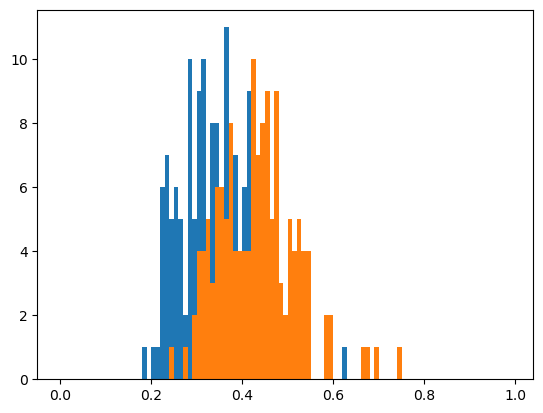

In [11]:
bins= np.arange(0.0, 1, 0.01)
uni = np.unique(res[0]['tdac'])
for u in uni:
    tmp = res[0][res[0]['tdac']==u]
    #tmp = res[res['tdac']==u]['fit'][:,1]
    plt.hist(tmp['quick_th'], bins=bins)
    print(tmp[['col', 'comp', 'tdac']][tmp['quick_th']>0.9])

In [81]:
import clicfast2023.analysis.data_loader as data_loader
importlib.reload(data_loader)
#fraw='/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/th_scan/20240527_190748_th_scan.h5'
#fraw = '/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/th_scan/20240527_205727_th_scan.h5'
fraw, fhit = data_loader.get_filename(fraw, datdir=None)

data_loader.analyze(fraw, fhit)
dat = data_loader.get_all_data(fhit)
param, extra_param =data_loader.get_scan_param(fraw, conf_name=['PixelConf.en_comp', 'inj.REPEAT'])
inj_n = extra_param['inj.REPEAT']
res_dtype = [('col', 'i'),('comp', 'i'),('quick_th', 'f'),('fit', 'f', 6)]
if len(param)>3:
    names = [*param.dtype.names[3:]]
    for n in names:
        res_dtype.append((n, param.dtype['cols'], param.dtype['cols'].shape))
else:
    names = []
    unipara=[0] ## dummy
res = np.empty(len(param)*data_loader.NCOMPS, dtype=res_dtype)
#unipara=np.unique(param[['tdac']])
i = 0
for up in unipara:
    if len(names)>0:
        ev = param['scan_param_id'][param[names]==up]
        print(ev)
    dat1 = dat[np.isin(dat['event_number'], ev)]
    unipix = np.unique(dat[['col','comp']])
    #if True:
    for u_i, upix in enumerate(unipix):
        dat0 = dat[dat[['col', 'comp']]==upix]
        uni, nhit = np.unique(dat0['event_number'], return_counts=True)
        arg = np.argsort(param['inj'][uni])
        x = param['inj'][uni][arg]
        y = nhit[arg]
        plt.plot(x, y, 'C{}o'.format(i%10),label='{}'.format(upix))
        try:
            res[i]['fit'] = fitfunctions.fit_scurve(x, y, A=100, reverse=False)
            plt.plot(x, fitfunctions.scurve(x, *res[i]['fit'][:3]), 'C{}-'.format(i%10))
        except:
            print('fitting error', upix)
            #plt.plot(x, fitfunctions.scurve(x, A=100, mu=0.5), '-')
            res[i]['fit'] = [np.nan]*6
        res[i]['col']=upix['col']
        res[i]['comp']=upix['comp']
        res[i]['quick_th']=fitfunctions.find_value(x, fitfunctions.find_arg(y, 50))
        for n in up.dtype.names:
            res[i][n]=up[n]
        i = i + 1
#plt.legend()
res = res[:i]


2024-05-29 11:12:56,285 - root - [INFO    ] (MainThread) interpreted /home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/injection_scan/20240529_103149_injection_hit.h5
2024-05-29 11:12:56,290 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=417
2024-05-29 11:12:56,291 - root - [INFO    ] (MainThread) 0.00s hit=13314/13314 event=12897 ts=31820/31820
2024-05-29 11:12:56,291 - root - [INFO    ] (MainThread) alingned to timestamp /home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/injection_scan/20240529_103149_injection_hit.h5


imcomplete ts (160599, 0, 3)
0.00s 160600/160600 hit=13314 ts=31820 trig=24


NameError: name 'unipara' is not defined

In [10]:
interpreter.raw2list(raw)

(array([( 52, 23, 5, 15, 14,  15, 16, 57609, 0),
        (177, 23, 5, 16, 15, 682, 70, 57619, 0)],
       dtype=[('event_number', '<i8'), ('col', 'u1'), ('comp', '<u2'), ('ts11', '<u2'), ('ts12', '<u2'), ('ts2', '<u2'), ('ts3', 'u1'), ('timestamp', '<u2'), ('err', 'u1')]),
 array([(  0, 247512314, 0), (  3, 247528698, 0), (  6, 247545082, 0),
        (  9, 247561466, 0), ( 12, 247577850, 0), ( 15, 247594234, 0),
        ( 18, 247610618, 0), ( 21, 247627002, 0), ( 24, 247643386, 0),
        ( 27, 247659770, 0), ( 30, 247676154, 0), ( 33, 247692538, 0),
        ( 36, 247708922, 0), ( 39, 247725306, 0), ( 42, 247741690, 0),
        ( 45, 247758074, 0), ( 53, 247774458, 0), ( 56, 247790842, 0),
        ( 59, 247807226, 0), ( 62, 247823610, 0), ( 65, 247839994, 0),
        ( 68, 247856378, 0), ( 71, 247872762, 0), ( 74, 247889146, 0),
        ( 77, 247905530, 0), ( 80, 247921914, 0), ( 83, 247938298, 0),
        ( 86, 247954682, 0), ( 89, 247971066, 0), ( 92, 247987450, 0),
        ( 95, 24

In [27]:
a=np.arange(10)
b=np.arange(0,30,3)
(a%2==0) & (b%2==0)

array([ True, False,  True, False,  True, False,  True, False,  True,
       False])

Exception in thread TcpReadoutThread:
Traceback (most recent call last):
  File "/home/thirono/miniconda3/lib/python3.11/threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "/home/thirono/miniconda3/lib/python3.11/threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "/home/thirono/Nextcloud-kit/workspace/basil/basil/TL/SiTcp.py", line 428, in _tcp_readout
    data = self._sock_tcp.recv(1024 * 8)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ConnectionResetError: [Errno 104] Connection reset by peer


## Injection Scan

In [26]:
import importlib
import clicfast2023.scans.injection_scan as injection_scan
importlib.reload(injection_scan)
scan = injection_scan.InjectionScan(dut=dut)
fraw = scan.start(inj=np.arange(0.02, 1.5, 0.01),
                  #tdac=[7, 0],
                  cols=None,
                  #cols=[1,2,3,4,5,6,7,8,9,10,11], #np.arange(0, dut.ncols, 1, dtype='i'), 
                  #cols=[1],
                  #comps=[10],
                  comps=None,
#                  tdac=[7,6,5,4,3,2,1,0]
                  disable_noninjected_pixel=True,
                  plsgen='inj')
#fhit = scan.analyze()

2024-05-29 13:17:44,371 - root - [INFO    ] (MainThread) Initializing InjectionScan
2024-05-29 13:17:44,371 - root - [INFO    ] (MainThread) Scan start time: 2024-05-29_13:17:44
2024-05-29 13:17:44,388 - root - [WARNING ] (MainThread) ScanBase.start:sender.init failed addr=tcp://127.0.0.1:6500
2024-05-29 13:17:44,389 - root - [INFO    ] (MainThread) set_rx: FIFO is not empty(32), try to discard the data...
2024-05-29 13:17:44,512 - root - [INFO    ] (MainThread) set_rx: FPGA alined: aligned=1
2024-05-29 13:17:44,512 - root - [INFO    ] (MainThread) Resetting Data-FIFO: size = 0
2024-05-29 13:17:44,614 - root - [INFO    ] (MainThread) Received words: 0
2024-05-29 13:17:44,614 - root - [INFO    ] (MainThread) Data queue size: 0
2024-05-29 13:17:44,614 - root - [INFO    ] (MainThread) SRAM FIFO size: 0
2024-05-29 13:17:44,615 - root - [INFO    ] (MainThread) Channel:                     CHIP_RX
2024-05-29 13:17:44,615 - root - [INFO    ] (MainThread) Discard counter:                0
2024

In [38]:
scan.close()

2024-05-29 11:48:32,210 - root - [INFO    ] (MainThread) fifo has been already closed


In [47]:
import clicfast2023.analysis.data_loader as data_loader
importlib.reload(data_loader)
importlib.reload(fitfunctions)
datdir = '/home/thirono/cernbox/clicfast2022/th_tuning'
fraw = '20240529_131744_injection_scan.h5'
fraw, fhit = data_loader.get_filename(fraw, datdir=datdir)

data_loader.analyze(fraw, fhit)
dat = data_loader.get_all_data(fhit)
param, extra_param =data_loader.get_scan_param(fraw, conf_name=['PixelConf.en_comp', 'inj.REPEAT'])
inj_n = extra_param['inj.REPEAT']
print('xxxxxxxxxxxxxx',len(dat))
res = data_loader.get_scurves(dat, param, inj_n=inj_n, outdir=fraw[:-8])
print('xxxxxxxxxxxxxx')

2024-05-29 13:29:45,771 - root - [INFO    ] (MainThread) interpreted /home/thirono/cernbox/clicfast2022/th_tuning/20240529_131744_injection_hit.h5


2024-05-29 13:29:45,780 - root - [INFO    ] (MainThread) 0.00s hit=121709/121709 event=121709 ts=14800/14800
2024-05-29 13:29:45,780 - root - [INFO    ] (MainThread) alingned to timestamp /home/thirono/cernbox/clicfast2022/th_tuning/20240529_131744_injection_hit.h5
2024-05-29 13:29:45,837 - root - [INFO    ] (MainThread) pix=(1, 0) 0 114
2024-05-29 13:29:45,869 - root - [INFO    ] (MainThread) pix=(1, 1) 0 117
2024-05-29 13:29:45,901 - root - [INFO    ] (MainThread) pix=(1, 2) 0 116
2024-05-29 13:29:45,932 - root - [INFO    ] (MainThread) pix=(1, 3) 0 106
2024-05-29 13:29:45,964 - root - [INFO    ] (MainThread) pix=(1, 4) 0 111


0.01s 652949/652949 hit=121709 ts=14800 trig=0
xxxxxxxxxxxxxx 121709
('scan_param_id', 'timestamp', 'inj')
[] [0]
up


2024-05-29 13:29:45,996 - root - [INFO    ] (MainThread) pix=(1, 5) 0 115
2024-05-29 13:29:46,028 - root - [INFO    ] (MainThread) pix=(1, 6) 0 117
2024-05-29 13:29:46,060 - root - [INFO    ] (MainThread) pix=(1, 7) 0 113
2024-05-29 13:29:46,091 - root - [INFO    ] (MainThread) pix=(1, 8) 0 116
2024-05-29 13:29:46,123 - root - [INFO    ] (MainThread) pix=(1, 9) 0 117
2024-05-29 13:29:46,154 - root - [INFO    ] (MainThread) pix=(1, 10) 0 87
2024-05-29 13:29:46,192 - root - [INFO    ] (MainThread) pix=(1, 11) 0 115


xxxxxxxxxxxxxx


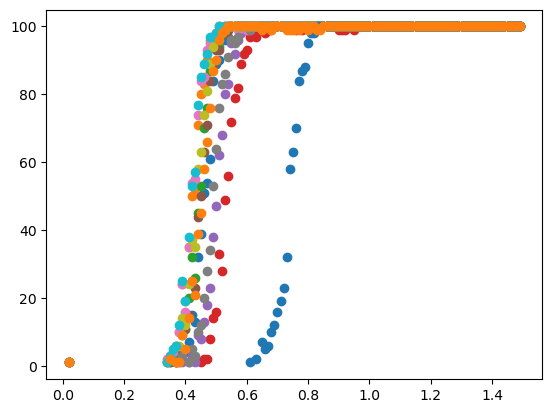

In [30]:
uni = np.unique(dat[['col', 'comp']])
for u in uni:
    dat0 = dat[dat[['col', 'comp']]==u]
    uni, nhit = np.unique(dat0['event_number'], return_counts=True)
    x = param['inj'][uni]
    plt.plot(x, nhit, 'o')

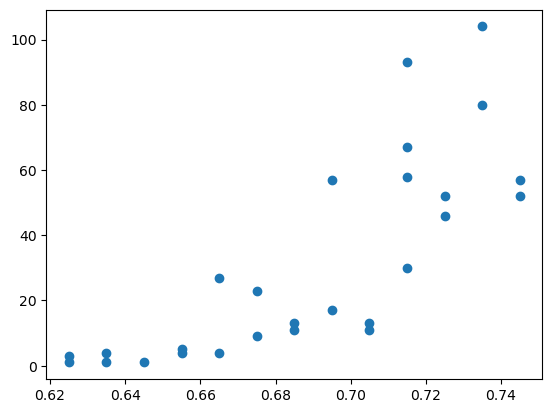

In [67]:
np.unique(dat[['col', 'comp']])
uni, nhit = np.unique(dat['event_number'], return_counts=True)
x = param['inj'][uni]
plt.plot(x, nhit, 'o')

## testing codes (scratch)

In [6]:
dut.save_config()



2024-06-05 18:25:17,587 - root - [INFO    ] (MainThread) save_config: /home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_182517_config.yaml


'/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/config/20240605_182517_config.yaml'

In [47]:
#np.isin(upix, enpix[0])
upix[0] in enpix[:,0] and upix[1] in enpix[:,1]

True

ValueError: `ydata` must not be empty!

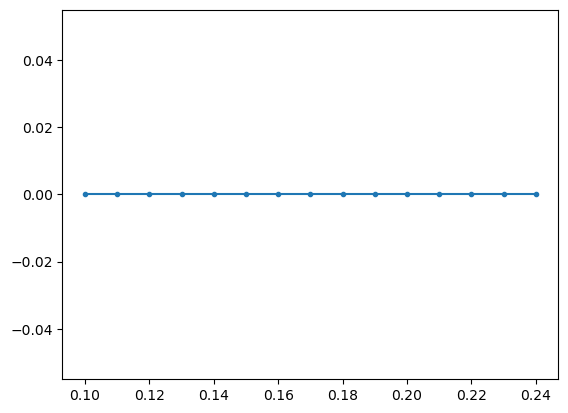

In [45]:
with tb.open_file(fhit) as f:
    dat = f.root.event_data[:]
with tb.open_file(fraw) as f:
    param = f.root.scan_parameters[:]

for comp_i in range(dut.ncomps):
    dat0 = dat[dat['comp']==comp_i]
    uni, idx= np.unique(dat0['timestamp'], return_index=True)
    #dat0 = dat0[idx]
    nhit = np.bincount(dat0['event_number'], minlength=len(param))
    arg=np.argsort(param['inj'])
    plt.plot(param['inj'][arg], nhit[arg], 'C{}.-'.format(comp_i))
    fit = fitfunc.fit_scurve(param['inj'][arg], nhit[arg], reverse=False)
    x = np.linspace(np.min(param['inj']),np.max(param['inj']),100)
    #plt.plot(x,fitfunc.scurve(x, *fit[:3]))
    if comp_i==1:
        break

plt.xlabel('Injection[V]')
plt.ylabel('#')
plt.legend()

In [46]:
nhit[arg]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
np.bincount(dat0['event_number'], minlength=len(param))
param[dat0['event_number']]['inj']

array([0.115, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.095, 0.105,
       0.105, 0.105, 0.115, 0.115, 0.115, 0.115, 0.115, 0.02 , 0.02 ,
       0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 , 0.02 ], dtype=float32)

In [6]:
import clicfast2023.analysis.interpreter as interpreter
importlib.reload(interpreter)
fraw = '/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/injection_scan/20240415_185741_injection_scan.h5'
fhit = fraw[:-7]+'hit.h5'
interpreter.interpret_h5(fraw, fhit)

FileNotFoundError: ``/home/thirono/Nextcloud-kit/workspace/clicfast2023/kit-gitlab/output/injection_scan/20240415_185741_injection_scan.h5`` does not exist

In [20]:
import clicfast2023.analysis.event_builder as event_builder
importlib.reload(event_builder)
event_builder.build_h5(fraw, fhit)

2024-04-15 19:15:23,848 - root - [INFO    ] (MainThread) BuildHit.run() n of error_hit=37
2024-04-15 19:15:23,850 - root - [INFO    ] (MainThread) 0.12s hit=153631/153631 event=153594 ts=12800/12800


In [19]:
dut.set_phase(128)
dut.set_phase(129)
dut.set_phase(130)
hex(dut['trig']["DELAY"] & 0xFFFC), hex(int(130//32))

2024-04-15 20:14:03,506 - root - [INFO    ] (MainThread) set_phase: trig_width=0x2a40 trig_delay=0x25c0 phase=0
2024-04-15 20:14:03,507 - root - [INFO    ] (MainThread) set_phase: trig_width=0x2a44 trig_delay=0x25bc phase=1
2024-04-15 20:14:03,508 - root - [INFO    ] (MainThread) set_phase: trig_width=0x2a48 trig_delay=0x25b8 phase=2


('0x2a48', '0x4')

Text(0.5, 1.0, 'Comparator1')

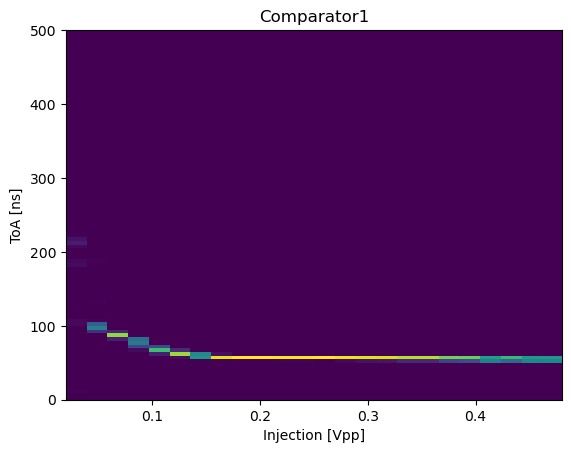

In [238]:
## timewalk
n = 100 #2**11
nsteps = param.shape[0]
toa = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    toa[:,i] = np.bincount(ev['toa'], minlength=n)[:n]

plt.imshow(toa, origin='lower', extent=(param['inj'][0], param['inj'][-1], 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToA [ns]')
plt.title('Comparator1')


Text(0.5, 1.0, 'Comparator1')

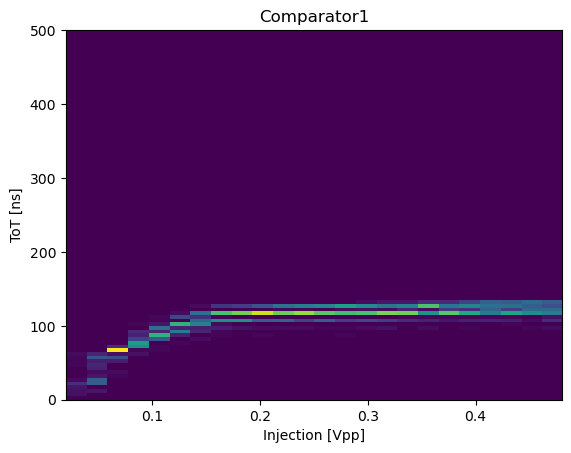

In [239]:
## timewalk
n = 100 #2**11
nsteps = param.shape[0]
tot = np.empty([n, nsteps])
for i in range(nsteps):
    ev = dat0[dat0['event_number']==i]
    tmp = np.array([
            ev['col']==col,
            ev['row']==row])
    ev = ev[np.all(tmp, axis=0)]
    tot[:,i] = np.bincount(ev['tot'], minlength=n)[:n]

plt.imshow(tot, origin='lower', extent=(param['inj'][0], param['inj'][-1], 0, n*5), aspect='auto')
plt.xlabel('Injection [Vpp]')
plt.ylabel('ToT [ns]')
plt.title('Comparator1')


In [30]:
dut.set_rx(False)

In [29]:
!netstat -anp |grep 192.168.10.16

(Not all processes could be identified, non-owned process info
 will not be shown, you would have to be root to see it all.)
tcp        0      0 192.168.10.1:59268      192.168.10.16:24        ESTABLISHED 215358/python       
udp        0      0 192.168.10.1:44349      192.168.10.16:4660      ESTABLISHED 215358/python       
